In [1]:
# import libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [2]:
# load the train and test dataset
train = pd.read_csv("train_u6lujuX_CVtuZ9i.csv")

In [3]:
# make a copy of original data
train_original = train.copy()

In [4]:
# take a look at the top 5 rows of the train set, notice the column "Loan_Status"
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
# show the shape of the dataset i.e. no of rows, no of columns
train.shape

(614, 13)

In [6]:
# show the data types for each column of the train set
train.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [7]:
# concise summary of the dataset, info about index dtype, column dtypes, non-null values and memory usage
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


## Hypothesis Genereration

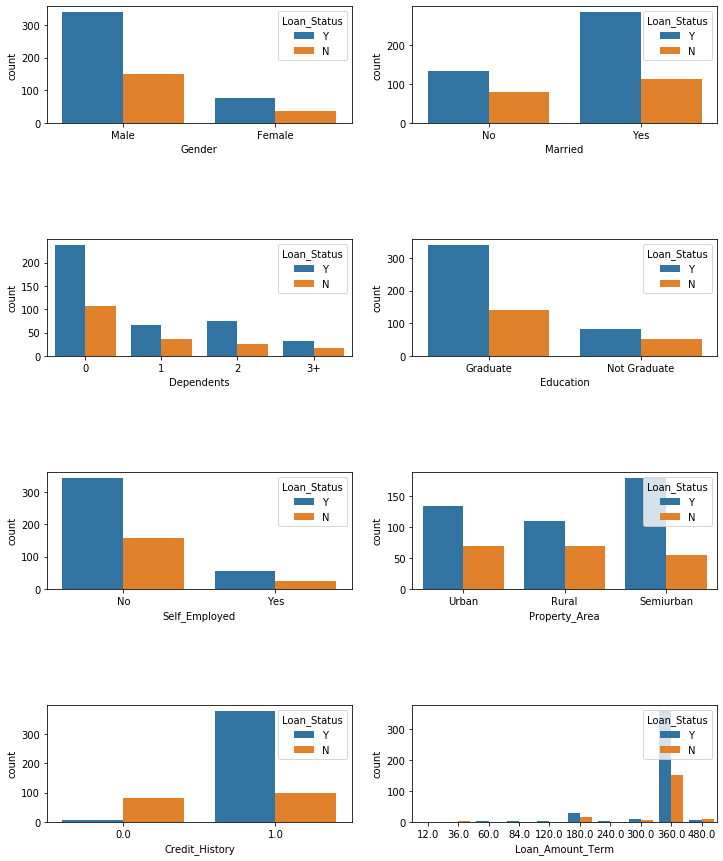

In [8]:
### Data Visualization libraries
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area','Credit_History','Loan_Amount_Term']
fig,axes = plt.subplots(4,2,figsize=(12,15))
for idx,cat_col in enumerate(categorical_columns):
    row,col = idx//2,idx%2
    sns.countplot(x=cat_col,data=train,hue='Loan_Status',ax=axes[row,col])
plt.subplots_adjust(hspace=1)

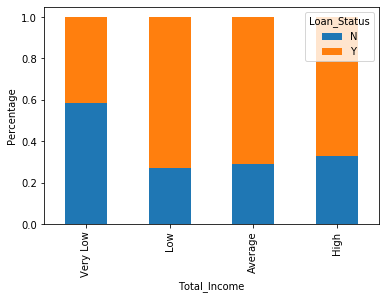

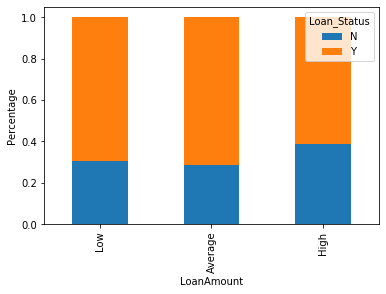

In [9]:
train['Total_Income'] = train['ApplicantIncome'] + train['CoapplicantIncome']
bins = [0,2500,4000,6000,81000]
group = ['Very Low','Low','Average', 'High']
train['Total_Income_bin'] = pd.cut(train['Total_Income'],bins,labels=group)
Total_Income_bin = pd.crosstab(train['Total_Income_bin'],train['Loan_Status'])
Total_Income_bin.div(Total_Income_bin.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.xlabel('Total_Income')
P = plt.ylabel('Percentage')

bins = [0,100,200,700]
group = ['Low','Average','High']
train['LoanAmount_bin'] = pd.cut(train['LoanAmount'],bins,labels=group)
LoanAmount_bin = pd.crosstab(train['LoanAmount_bin'],train['Loan_Status'])
LoanAmount_bin.div(LoanAmount_bin.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.xlabel('LoanAmount')
P = plt.ylabel('Percentage')

### From the above graphs, Hypothesis generation
- Men have higher rate of receiving a loan than women. <br>
- Married people have a higher shot at getting loan than unmarried people. <br>
- As the number of dependents increase the change of you getting a loan decreases. <br>
- Higher the Education Level i.e. graduate level higher is the rate of approval of loan. <br>
- People with jobs have an easier time getting a loan approved than self - employed people. <br>
- While semiurban has the highes approval rate, the rejection rate in all three of the categories is comparitively the same. <br>
- Applicants who have repayed their previous debts should have higher chances of loan approval. <br>
- Majority of the loans taken are for 360 months. <br>
- High income will have more chances of loan approval. <br>
- The chances of loan approval will be high when the loan amount is less. <br>

In [10]:
train= train.drop([ 'LoanAmount_bin', 'Total_Income_bin','Total_Income'], axis=1)

In [11]:
# replacing 3+ in Dependents variable with 3 for both train and test set
train['Dependents'].replace('3+', 3, inplace=True)

In [12]:
# replacing Y and N in Loan_Status variable with 1 and 0 respectively
train['Loan_Status'].replace('N', 0, inplace=True)
train['Loan_Status'].replace('Y', 1, inplace=True)

In [13]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,1
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1


# Data Pre-processing


### Missing value imputation

In [14]:
# check for missing values
train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [15]:
def isNaN(string):
    return str(string) != string
                   
# Replace categorical missing values in train and test with the mode

train['Gender'] = train['Gender'].replace(np.nan, train['Gender'].mode()[0], regex=True)
train['Married'] = train['Married'].replace(np.nan, train['Married'].mode()[0], regex=True)
train['Dependents'] = train['Dependents'].replace(np.nan, train['Dependents'].mode()[0], regex=True)
train['Self_Employed'] = train['Self_Employed'].replace(np.nan, train['Self_Employed'].mode()[0], regex=True)
train['Credit_History'] = train['Credit_History'].replace(np.nan, train['Credit_History'].mode()[0], regex=True)

In [16]:
train.isnull().sum()

Loan_ID               0
Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

In [17]:
# Replace continuous values with the median for train
median_loanAmount = train['LoanAmount'].median()
median_loanAmount

# Replace continuous values with the median for test
train['LoanAmount'] = train['LoanAmount'].replace(np.nan, median_loanAmount, regex=True)
train['LoanAmount'].fillna(median_loanAmount, inplace=True)

# Replace continuous values with the median for train
train['Loan_Amount_Term'].value_counts()
train['Loan_Amount_Term'].fillna(360, inplace=True)

In [18]:
train.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [19]:
print(train.apply(lambda x: len(x.unique())))

Loan_ID              614
Gender                 2
Married                2
Dependents             4
Education              2
Self_Employed          2
ApplicantIncome      505
CoapplicantIncome    287
LoanAmount           203
Loan_Amount_Term      10
Credit_History         2
Property_Area          3
Loan_Status            2
dtype: int64


## Feature Engineering

Based on the domain knowledge, we can come up with new features that might affect the target variable. We will create the following three new features:

- <div style="text-align: justify"> <b>Total Income</b> - As discussed during bivariate analysis we will combine the Applicant Income and Coapplicant Income. If the total income is high, chances of loan approval might also be high. </div>
- <div style="text-align: justify"> <b>Equated Monthly Installment</b> - EMI is the monthly amount to be paid by the applicant to repay the loan. Idea behind making this variable is that people who have high EMI’s might find it difficult to pay back the loan. We can calculate the EMI by taking the ratio of loan amount with respect to loan amount term. </div>
- <div style="text-align: justify"> <b>Balance Income</b> - This is the income left after the EMI has been paid. Idea behind creating this variable is that if this value is high, the chances are high that a person will repay the loan and hence increasing the chances of loan approval. </div>

In [20]:
#calculate total income 
train['Total_Income']=train['ApplicantIncome'] + train['CoapplicantIncome']

In [21]:
# create EMI feature
train['EMI'] = train['LoanAmount'] / train['Loan_Amount_Term']

In [22]:
# create new "Balance Income" variable
train['Balance Income'] = train['Total_Income'] - (train['EMI']*1000) # Multiply with 1000 to make the units equal 

In [23]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income,EMI,Balance Income
0,LP001002,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,1,5849.0,0.355556,5493.444444
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0,6091.0,0.355556,5735.444444
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1,3000.0,0.183333,2816.666667
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1,4941.0,0.333333,4607.666667
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1,6000.0,0.391667,5608.333333


In [24]:
# drop Loan_ID 
train = train.drop(['Loan_ID','ApplicantIncome','CoapplicantIncome','Loan_Amount_Term'], axis=1)

In [25]:
# adding dummies to the dataset
train = pd.get_dummies(train)

In [54]:
train.head()

,LoanAmount,Credit_History,Loan_Status,Total_Income,EMI,Balance Income,Gender_Female,Gender_Male,Married_No,Married_Yes,...,Dependents_0,Dependents_1,Dependents_2,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,128.0,1.0,1,5849.0,0.355556,5493.444444,0,1,1,0,...,1,0,0,1,0,1,0,0,0,1
1,128.0,1.0,0,6091.0,0.355556,5735.444444,0,1,0,1,...,0,1,0,1,0,1,0,1,0,0
2,66.0,1.0,1,3000.0,0.183333,2816.666667,0,1,0,1,...,1,0,0,1,0,0,1,0,0,1
3,120.0,1.0,1,4941.0,0.333333,4607.666667,0,1,0,1,...,1,0,0,0,1,1,0,0,0,1
4,141.0,1.0,1,6000.0,0.391667,5608.333333,0,1,1,0,...,1,0,0,1,0,1,0,0,0,1


In [27]:
# drop "Loan_Status" and assign it to target variable
X = train.drop('Loan_Status', 1)
y = train.Loan_Status

## Split dataset into test and train

In [28]:
# split the data into train and cross validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

## We will build the following models in this section.

- Logistic Regression
- Decision Tree
- Random Forest
- Naive Baiyes 
- Support Vector Machine 

# Logistic Regression

In [57]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [58]:
# make prediction
predictions = model.predict(X_test)
#accuracy
score = model.score(X_test, y_test)
print(score*100)

77.29729729729729


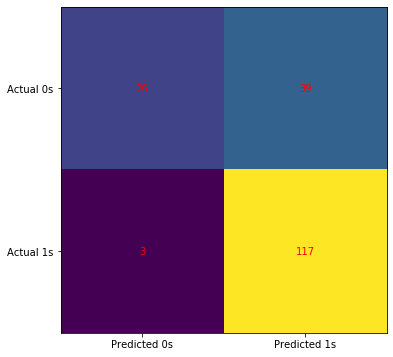

In [31]:
cm = confusion_matrix(y_test, model.predict(X_test))

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

### with K fold cross validation with 10 folds

In [32]:
model = LogisticRegression(random_state=1)
accuracy = cross_val_score(model, X, y, scoring='accuracy', cv = 10)
print(accuracy)
#get the mean of each fold 
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)


[0.79365079 0.82539683 0.75409836 0.75409836 0.78688525 0.78688525
 0.86885246 0.85245902 0.80327869 0.83606557]
Accuracy of Model with Cross Validation is: 80.6167056986729


# Decision Tree

In [33]:
# import library
from sklearn import tree

In [73]:
model = tree.DecisionTreeClassifier(random_state=1)
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

In [74]:
# make prediction
predictions = model.predict(X_test)
#accuracy
score = model.score(X_test, y_test)
print(score*100)

72.97297297297297


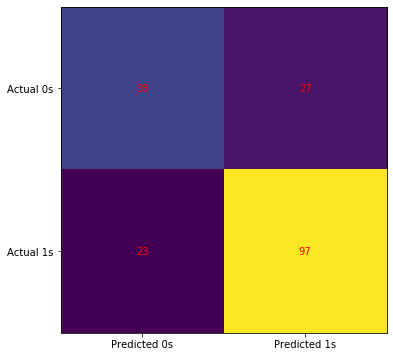

In [75]:
cm = confusion_matrix(y_test, model.predict(X_test))

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

### with K fold cross validation with 10 folds

In [82]:
model = tree.DecisionTreeClassifier()
accuracy = cross_val_score(model, X, y, scoring='accuracy', cv = 10)
print(accuracy)
#get the mean of each fold 
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

[0.68253968 0.73015873 0.73770492 0.72131148 0.6557377  0.70491803
 0.80327869 0.81967213 0.72131148 0.75409836]
Accuracy of Model with Cross Validation is: 73.30731199583657


# Random Forest

In [38]:
# import library
from sklearn.ensemble import RandomForestClassifier

In [69]:
model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [70]:
# make prediction
predictions = model.predict(X_test)
#accuracy
score = model.score(X_test, y_test)
print(score*100)

73.51351351351352


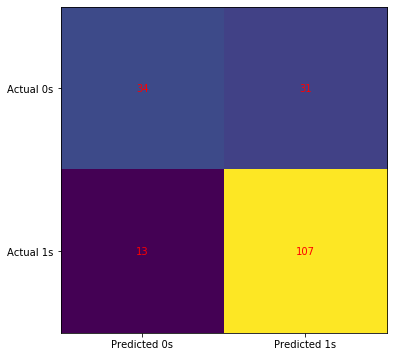

In [41]:
cm = confusion_matrix(y_test, model.predict(X_test))

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

### with K fold cross validation with 10 folds

In [72]:
model = RandomForestClassifier(random_state=42, max_depth=10, n_estimators=10)
accuracy = cross_val_score(model, X, y, scoring='accuracy', cv = 10)
print(accuracy)
#get the mean of each fold 
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

[0.76190476 0.79365079 0.73770492 0.75409836 0.73770492 0.7704918
 0.81967213 0.7704918  0.78688525 0.80327869]
Accuracy of Model with Cross Validation is: 77.35883424408014


# Naive Bayes

In [43]:
# import library
from sklearn.naive_bayes import GaussianNB

In [83]:
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [85]:
# make prediction
predictions = model.predict(X_test)
#accuracy
score = model.score(X_test, y_test)
print(score*100)

78.91891891891892


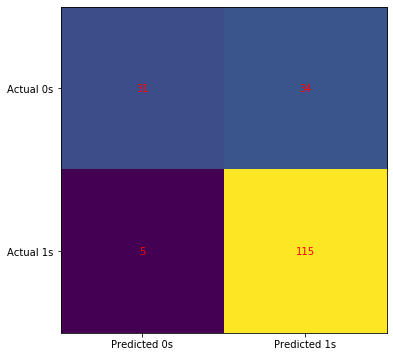

In [46]:
cm = confusion_matrix(y_test, model.predict(X_test))

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

### with K fold cross validation with 10 folds

In [47]:
model = GaussianNB()
accuracy = cross_val_score(model, X, y, scoring='accuracy', cv = 10)
print(accuracy)
#get the mean of each fold 
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

[0.80952381 0.82539683 0.72131148 0.75409836 0.80327869 0.7704918
 0.83606557 0.81967213 0.75409836 0.86885246]
Accuracy of Model with Cross Validation is: 79.6278948737965


# Support Vector Machine

In [48]:
# import library
from sklearn import svm

In [86]:
model = svm.SVC()
model.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [87]:
# make prediction
predictions = model.predict(X_test)
#accuracy
score = model.score(X_test, y_test)
print(score*100)

65.4054054054054


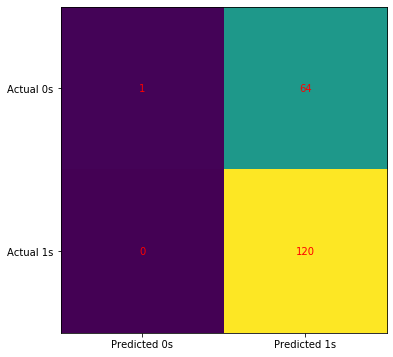

In [51]:
cm = confusion_matrix(y_test, model.predict(X_test))

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

### with K fold cross validation with 10 folds

In [52]:
model = svm.SVC()
accuracy = cross_val_score(model, X, y, scoring='accuracy', cv = 10)
print(accuracy)
#get the mean of each fold 
print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)

[0.66666667 0.68253968 0.68852459 0.68852459 0.68852459 0.70491803
 0.68852459 0.70491803 0.67213115 0.68852459]
Accuracy of Model with Cross Validation is: 68.73796513140775
